In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import time
import os
import pandas as pd
from dataclasses import dataclass
from collections import namedtuple
import pyro
import optax
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import genjax
from genjax import grasp

key = jax.random.PRNGKey(314159)
console = genjax.pretty()
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
label_fontsize = 70  # Set the desired font size here

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

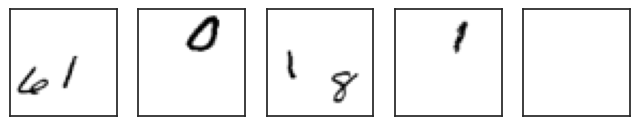

In [2]:
inpath = "./data/air/.data"
X_np, Y = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = jnp.array(X_np)
true_counts = jnp.array([len(objs) for objs in Y])


def show_images(imgs):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")


show_images(mnist[9:14])

## Defining the variational ingredients

### Utilities / learnable pieces

In [3]:
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

# Utilities for defining the model and the guide.


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(50, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 400, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)

# Create our RNN for the guide.
key, sub_key = jax.random.split(key)
rnn = eqx.nn.LSTMCell(2554, 256, key=sub_key)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(400, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 100, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:50], jax.nn.softplus(v[50:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@dataclass
class Predict(Pytree):
    dense: Any

    def flatten(self):
        return (self.dense,), ()

    @classmethod
    def new(cls, key):
        dense = eqx.nn.Linear(256, 7, key=key)
        return Predict(dense)

    def __call__(self, h):
        a = self.dense(h)
        z_pres_p = jax.nn.sigmoid(a[0:1])
        z_where_loc = a[1:4]
        z_where_scale = jax.nn.softplus(a[4:])
        return z_pres_p, z_where_loc, z_where_scale


key, sub_key = jax.random.split(key)
predict = Predict.new(key)

In [4]:
#######
# STN #
#######

# modified from https://github.com/kevinzakka/spatial-transformer-network/blob/master/stn/transformer.py


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.

    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.

    - width: desired width of grid/output. Used
      to downsample or upsample.

    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.

    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.

    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = theta.shape[0]

    # create normalized 2D grid
    x = jnp.linspace(-1.0, 1.0, width)
    y = jnp.linspace(-1.0, 1.0, height)
    x_t, y_t = jnp.meshgrid(x, y)

    # flatten
    x_t_flat = jnp.reshape(x_t, [-1])
    y_t_flat = jnp.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = jnp.ones_like(x_t_flat)
    sampling_grid = jnp.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = jnp.expand_dims(sampling_grid, axis=0)
    sampling_grid = jnp.tile(sampling_grid, [num_batch, 1, 1])

    # transform the sampling grid - batch multiply
    batch_grids = jnp.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, 2, H, W)
    batch_grids = jnp.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.

    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = jnp.shape(img)[1]
    W = jnp.shape(img)[2]
    max_y = H - 1
    max_x = W - 1
    zero = jnp.zeros([], dtype=int)

    # rescale x and y to [0, W-1/H-1]
    x = 0.5 * ((x + 1.0) * max_x - 1)
    y = 0.5 * ((y + 1.0) * max_y - 1)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = jnp.clip(x0, zero, max_x)
    x1 = jnp.clip(x1, zero, max_x)
    y0 = jnp.clip(y0, zero, max_y)
    y1 = jnp.clip(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = x0.astype(float)
    x1 = x1.astype(float)
    y0 = y0.astype(float)
    y1 = y1.astype(float)

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = jnp.expand_dims(wa, axis=3)
    wb = jnp.expand_dims(wb, axis=3)
    wc = jnp.expand_dims(wc, axis=3)
    wd = jnp.expand_dims(wd, axis=3)

    # compute output
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.

    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)

    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    batch_size, height, width = jnp.shape(x)

    batch_idx = jnp.arange(0, batch_size)
    batch_idx = jnp.reshape(batch_idx, (batch_size, 1, 1))
    b = jnp.tile(batch_idx, (1, height, width))

    indices = jnp.stack([b, y, x], 3)

    return gather_nd(img, indices)


# from: https://github.com/google/jax/discussions/6119
def gather_nd_unbatched(params, indices):
    return params[tuple(jnp.moveaxis(indices, -1, 0))]


def gather_nd(params, indices, batch=False):
    if not batch:
        return gather_nd_unbatched(params, indices)
    else:
        return vmap(gather_nd_unbatched, (0, 0), 0)(params, indices)


def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = 1
    expansion_indices = jnp.array([1, 0, 2, 0, 1, 3])
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.concatenate((jnp.broadcast_to(jnp.zeros([1, 1]), (n, 1)), z_where), 1)
    return jnp.reshape(out[:, expansion_indices], (n, 2, 3))


def object_to_image(z_where, obj):
    n = 1
    theta = expand_z_where(z_where)
    grid = affine_grid_generator(50, 50, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(obj, (n, 20, 20, 1)), x_s, y_s)
    return jnp.reshape(out, (50, 50))


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = 1
    out = jnp.array([1, *(-z_where[1:])])
    out = out / z_where[0]
    return out


def image_to_object(z_where, image):
    n = 1
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid_generator(20, 20, theta_inv)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(image, (n, 50, 50, 1)), x_s, y_s)
    return jnp.reshape(out, (400,))

### Model

In [5]:
#########
# Model #
#########

# Fixed constants.
z_where_prior_loc = jnp.array([3.0, 0.0, 0.0])
z_where_prior_scale = jnp.array([0.2, 1.0, 1.0])
z_what_prior_loc = jnp.zeros(50, dtype=float)
z_what_prior_scale = jnp.ones(50, dtype=float)
z_pres_prior = 0.008
eps = 1e-4


@genjax.gen
@typecheck
def step(
    t: Int,
    decoder: Decoder,
    prev_x: FloatArray,
    prev_z_pres: IntArray,
):
    z_pres = grasp.flip_reinforce(z_pres_prior ** (2 * t + 1)) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = (
        grasp.mv_normal_diag_reparam(z_where_prior_loc, z_where_prior_scale)
        @ f"z_where_{t}"
    )
    z_what = (
        grasp.mv_normal_diag_reparam(z_what_prior_loc, z_what_prior_scale)
        @ f"z_what_{t}"
    )
    y_att = decoder(z_what)
    y = object_to_image(z_where, y_att)
    x = prev_x + (y * z_pres)
    return x, z_pres


# TODO: Make sure that this works, where t is a static int.
@genjax.gen
@typecheck
def model(decoder: Decoder):
    x = jnp.zeros((50, 50), dtype=float)
    z_pres = jnp.ones(1, dtype=int)
    for t in range(3):
        x, z_pres = step.inline(t, decoder, x, z_pres)
    obs = grasp.mv_normal_diag_reparam(x, 0.3 * jnp.ones_like(x)) @ "obs"
    return x

#### Samples from the model

In [6]:
tr = jax.jit(model.simulate)(key, (decoder,))
tr.strip()




├── :z_what_2
│   └──  f32[50]
├── :z_pres_1
│   └──  bool[]
├── :z_pres_0
│   └──  bool[]
├── :obs
│   └──  f32[50,50]
├── :z_pres_2
│   └──  bool[]
├── :z_where_0
│   └──  f32[3]
├── :z_what_1
│   └──  f32[50]
├── :z_what_0
│   └──  f32[50]
├── :z_where_2
│   └──  f32[3]
└── :z_where_1
    └──  f32[3]

### Guide

In [7]:
#########
# Guide #
#########


@genjax.gen
@typecheck
def guide_step(
    t: Int,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
    data,
    prev: Tuple,
):
    (prev_z_where, prev_z_what, prev_z_pres, prev_h, prev_c) = prev
    rnn_input = jnp.concatenate([data, prev_z_where, prev_z_what, prev_z_pres])
    h, c = rnn(rnn_input, (prev_h, prev_c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)
    z_pres = (
        grasp.flip_reinforce((eps + (z_pres_p[0] * prev_z_pres[0])) / (1 + 2 * eps))
        @ f"z_pres_{t}"
    )
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = grasp.mv_normal_diag_reparam(z_where_loc, z_where_scale) @ f"z_where_{t}"
    x_att = image_to_object(z_where, data)
    z_what_loc, z_what_scale = encoder(x_att)
    z_what = grasp.mv_normal_diag_reparam(z_what_loc, z_what_scale) @ f"z_what_{t}"
    return z_where, z_what, z_pres, h, c


@genjax.gen
@typecheck
def guide(
    data: genjax.ChoiceMap,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
):
    h = jnp.zeros(256)
    c = jnp.zeros(256)
    z_pres = jnp.ones(1)
    z_where = jnp.zeros(3)
    z_what = jnp.zeros(50)
    img = data["obs"]
    img_arr = img.flatten()

    for t in range(3):
        (z_where, z_what, z_pres, h, c) = guide_step.inline(
            t, rnn, encoder, predict, img_arr, (z_where, z_what, z_pres, h, c)
        )

#### Samples from the guide

In [8]:
data_chm = genjax.choice_map({"obs": jnp.ones((50, 50))})
tr = jax.jit(guide.simulate)(key, (data_chm, rnn, encoder, predict))
tr.strip()




├── :z_what_2
│   └──  f32[50]
├── :z_pres_1
│   └──  bool[]
├── :z_pres_0
│   └──  bool[]
├── :z_pres_2
│   └──  bool[]
├── :z_where_0
│   └──  f32[3]
├── :z_what_1
│   └──  f32[50]
├── :z_what_0
│   └──  f32[50]
├── :z_where_2
│   └──  f32[3]
└── :z_where_1
    └──  f32[3]

## Training

### Make sure grads are working

#### Define ELBO objective

In [9]:
data = genjax.choice_map({"obs": jnp.ones((50, 50))})
objective = grasp.elbo(model, guide, data)

#### Go go grads

In [10]:
jitted = jax.jit(objective.value_and_grad_estimate)
loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
    key, ((decoder,), (data, rnn, encoder, predict))
)

In [11]:
loss

Array(-13631.906, dtype=float32)

### Dataloader

In [12]:
def data_loader(
    data,
    batch_size,
    shuffle=True,
):
    N = len(data)
    data_idxs = np.arange(N)
    num_batch = int(np.ceil(N // batch_size))

    def init(key):
        return (
            num_batch,
            jax.random.permutation(key, data_idxs) if shuffle else data_idxs,
        )

    def get_batch(i=0, idxs=data_idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return jax.lax.index_take(data, (ret_idx,), axes=(0,))

    return init, get_batch

In [13]:
##################
# Count Accuracy #
##################


def count_accuracy(data, true_counts, guide, batch_size=1000):
    global prng_key
    assert data.shape[0] == true_counts.shape[0], "Size mismatch."
    assert data.shape[0] % batch_size == 0, "Input size must be multiple of batch_size."

    def eval_guide(key, data, params):
        data_chmp = genjax.choice_map({"obs": data})
        return guide.simulate(key, (data_chmp, *params))

    batch_eval_guide = jax.vmap(eval_guide, in_axes=(0, 0, None))

    @jax.jit
    def evaluate_count_accuracy(key, params):
        def evaluate_batch(counts, batch_id):
            data_batch = jax.lax.dynamic_slice_in_dim(
                data, batch_id * batch_size, batch_size
            )
            true_counts_batch = jax.lax.dynamic_slice_in_dim(
                true_counts, batch_id * batch_size, batch_size
            )
            data_chmp = genjax.choice_map({"obs": data_batch})
            # evaluate guide
            keys = jax.random.split(jax.random.fold_in(key, batch_id), batch_size)
            tr = batch_eval_guide(keys, data_batch, params)
            z_where = [tr[f"z_where_{i}"] for i in range(3)]
            z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
            # compute stats
            inferred_counts = sum(z for z in z_pres)
            true_counts_m = jax.nn.one_hot(true_counts_batch, 3)
            inferred_counts_m = jax.nn.one_hot(inferred_counts, 4)
            counts += (true_counts_m.T @ inferred_counts_m).astype(int)
            error_ind = 1 - (true_counts_batch == inferred_counts).astype(int)
            # error_ix = error_ind.nonzero()[0]
            # error_latent = jnp.take(latents_to_tensor((z_where, z_pres)), error_ix, 0)
            return counts, error_ind

        counts = jnp.zeros((3, 4), dtype=int)
        counts, error_indices = jax.lax.scan(
            evaluate_batch, counts, jnp.arange(data.shape[0] // batch_size)
        )

        acc = jnp.sum(jnp.diag(counts)).astype(float) / data.shape[0]
        error_indices = jnp.concatenate(
            error_indices
        )  # .nonzero()[0]  # <- not JIT compilable
        return acc, counts, error_indices

    return evaluate_count_accuracy


# Combine z_pres and z_where (as returned by the model and guide) into
# a single tensor, with size:
# [batch_size, num_steps, z_where_size + z_pres_size]
def latents_to_tensor(z):
    return jnp.stack(
        [
            jnp.concatenate((z_where, z_pres.reshape(-1, 1)), 1)
            for z_where, z_pres in zip(*z)
        ]
    ).transpose(1, 0, 2)

In [14]:
##################
# Visualization  #
##################


def bounding_box(z_where, x_size):
    """This doesn't take into account interpolation, but it's close
    enough to be usable."""
    w = x_size / z_where.s
    h = x_size / z_where.s
    xtrans = -z_where.x / z_where.s * x_size / 2.0
    ytrans = -z_where.y / z_where.s * x_size / 2.0
    x = (x_size - w) / 2 + xtrans  # origin is top left
    y = (x_size - h) / 2 + ytrans
    return (x, y), w, h


z_obj = namedtuple("z", ["s", "x", "y", "pres"])


# Map a tensor of latents (as produced by latents_to_tensor) to a list
# of z_obj named tuples.
def tensor_to_objs(latents):
    return [[z_obj._make(step) for step in z] for z in latents]


def visualize_model(model, guide):
    def reconstruct_digits(key, data, params):
        decoder, rnn, encoder, predict = params
        data_chmp = genjax.choice_map({"obs": data})
        key1, key2 = jax.random.split(key)
        tr = guide.simulate(key1, (data_chmp, rnn, encoder, predict))
        _, tr = model.importance(key2, tr, (decoder,))
        reconstruction = tr.get_retval()
        z_where = [tr[f"z_where_{i}"] for i in range(3)]
        z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
        return reconstruction, (z_where, z_pres)

    batch_reconstruct_digits = jax.jit(
        jax.vmap(reconstruct_digits, in_axes=(0, 0, None))
    )

    def visualize(key, params, examples_to_viz):
        keys = jax.random.split(key, examples_to_viz.shape[0])
        recons, z = batch_reconstruct_digits(keys, examples_to_viz, params)
        z_wheres = tensor_to_objs(latents_to_tensor(z))
        draw_many(examples_to_viz.reshape(-1, 50, 50), z_wheres, title="Original")
        draw_many(recons, z_wheres, title="Reconstruction")

    return visualize


def colors(k):
    return ["r", "g", "b"][k % 3]


def draw_one(img, z):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray_r")
    for k, z in enumerate(z):
        if z.pres > 0:
            (x, y), w, h = bounding_box(z, img.shape[0])
            plt.gca().add_patch(
                Rectangle(
                    (x, y), w, h, linewidth=1, edgecolor=colors(k), facecolor="none"
                )
            )


def draw_many(imgs, zs, title):
    plt.figure(figsize=(8, 1.9))
    plt.title(title)
    plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.box(False)
    for i, (img, z) in enumerate(zip(imgs, zs)):
        plt.subplot(1, len(imgs), i + 1)
        draw_one(img, z)
    plt.show()

In [15]:
params = (decoder, rnn, encoder, predict)
evaluate_accuracy = count_accuracy(mnist, true_counts, guide, batch_size=1000)

visualize_examples = mnist[5:10]
visualize = visualize_model(model, guide)

In [16]:
def train(key, n=1, num_epochs=200, batch_size=64, learning_rate=1.0e-4):
    def svi_update(model, guide, optimiser):
        def batch_updater(key, params, opt_state, data_batch):
            def grads(key, params, data):
                (decoder, rnn, encoder, predict) = params
                data = genjax.choice_map({"obs": data})
                objective = grasp.iwae_elbo(model, guide, data, n)
                loss, (
                    (decoder_grads,),
                    (_, rnn_grads, encoder_grads, predict_grads),
                ) = objective.value_and_grad_estimate(
                    key, ((decoder,), (data, rnn, encoder, predict))
                )
                return loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads)

            sub_keys = jax.random.split(key, len(data_batch))
            loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads) = jax.vmap(
                grads, in_axes=(0, None, 0)
            )(sub_keys, params, data_batch)

            grads = jtu.tree_map(
                lambda v: -1.0 * jnp.mean(v, axis=0),
                (decoder_grads, rnn_grads, encoder_grads, predict_grads),
            )
            updates, opt_state = optimiser.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss = jnp.mean(loss)
            return params, opt_state, loss

        return batch_updater

    adam = optax.adam(learning_rate)
    svi_updater = svi_update(model, guide, adam)
    train_init, train_fetch = data_loader(jnp.array(mnist), batch_size)
    key, sub_key = jax.random.split(key)
    num_batch, train_idx = train_init(sub_key)

    @jax.jit
    def epoch_train(opt_state, params, key, train_idx):
        def body_fn(carry, xs):
            idx, params, opt_state, loss = carry
            updater_key = jax.random.fold_in(key, idx)
            batch = train_fetch(idx, train_idx)
            params, opt_state, loss = svi_updater(updater_key, params, opt_state, batch)
            idx += 1
            return (idx, params, opt_state, loss), loss

        idx = 0
        (_, params, opt_state, _), losses = jax.lax.scan(
            body_fn, (idx, params, opt_state, 0.0), None, length=num_batch
        )
        return params, opt_state, losses

    # Train.
    params = (decoder, rnn, encoder, predict)
    opt_state = adam.init(params)
    losses = []
    accuracy = []
    wall_clock_times = []

    # Warm up.
    _ = epoch_train(opt_state, params, key, train_idx)

    t0 = time.perf_counter()
    acc_time = 0.0
    for i in range(0, num_epochs + 1):
        key, sub_key = jax.random.split(key)
        num_batch, train_idx = train_init(sub_key)
        key, sub_key = jax.random.split(key)
        start = time.perf_counter() - t0
        params, opt_state, loss = epoch_train(opt_state, params, sub_key, train_idx)
        stop = time.perf_counter() - t0
        acc_time += stop - start
        wall_clock_times.append(acc_time)
        print(
            f"Epoch={i}, total_epoch_step_time={acc_time:.2f}, loss={jnp.mean(loss):.2f}"
        )
        losses.append(jnp.mean(loss))
        acc, counts, error_ix = evaluate_accuracy(sub_key, params[1:])
        accuracy.append(acc)
        if i % 10 == 0:
            print("accuracy={}, counts={}".format(acc, counts))
            visualize(sub_key, params, visualize_examples)

    return losses, accuracy, wall_clock_times, params

Epoch=0, total_epoch_step_time=1.35, loss=-79.76
accuracy=0.242249995470047, counts=[[11163  7434  1306    45]
 [16564  3357    98     1]
 [18829  1188    15     0]]


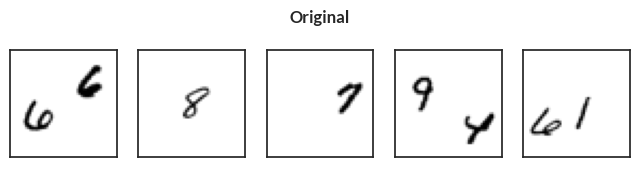

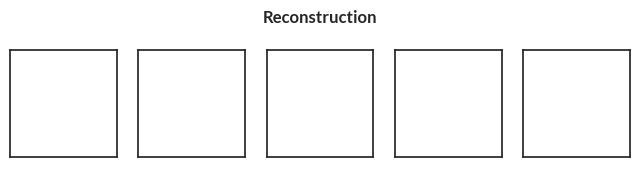

Epoch=1, total_epoch_step_time=2.74, loss=399.06
Epoch=2, total_epoch_step_time=4.15, loss=419.76
Epoch=3, total_epoch_step_time=5.58, loss=438.16
Epoch=4, total_epoch_step_time=7.05, loss=451.21
Epoch=5, total_epoch_step_time=8.50, loss=456.09
Epoch=6, total_epoch_step_time=9.93, loss=457.54
Epoch=7, total_epoch_step_time=11.38, loss=458.58
Epoch=8, total_epoch_step_time=12.78, loss=459.25
Epoch=9, total_epoch_step_time=14.36, loss=459.54
Epoch=10, total_epoch_step_time=15.73, loss=459.69
accuracy=0.2999333441257477, counts=[[14041  5515   384     8]
 [15967  3799   244    10]
 [16733  3137   156     6]]


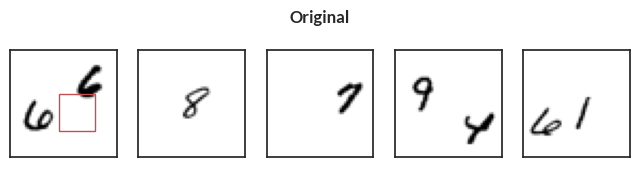

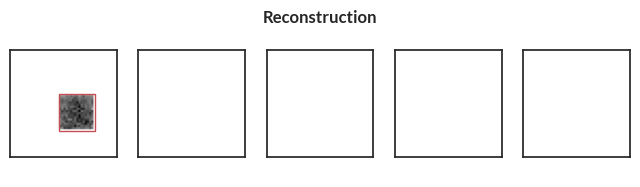

Epoch=11, total_epoch_step_time=17.10, loss=460.26
Epoch=12, total_epoch_step_time=18.46, loss=462.80
Epoch=13, total_epoch_step_time=19.83, loss=468.26
Epoch=14, total_epoch_step_time=21.19, loss=474.67
Epoch=15, total_epoch_step_time=22.59, loss=481.61
Epoch=16, total_epoch_step_time=23.99, loss=497.30
Epoch=17, total_epoch_step_time=25.39, loss=511.07
Epoch=18, total_epoch_step_time=26.78, loss=522.46
Epoch=19, total_epoch_step_time=28.17, loss=530.95
Epoch=20, total_epoch_step_time=29.58, loss=538.25
accuracy=0.7571166753768921, counts=[[14597  5339    12     0]
 [  753 16888  2365    14]
 [   42  5448 13942   600]]


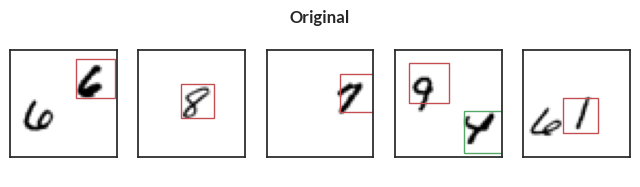

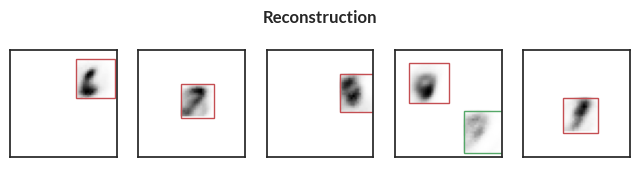

Epoch=21, total_epoch_step_time=31.11, loss=546.22
Epoch=22, total_epoch_step_time=32.64, loss=552.34
Epoch=23, total_epoch_step_time=34.12, loss=557.91
Epoch=24, total_epoch_step_time=35.52, loss=562.05
Epoch=25, total_epoch_step_time=36.98, loss=565.13
Epoch=26, total_epoch_step_time=38.45, loss=567.82
Epoch=27, total_epoch_step_time=39.97, loss=572.28
Epoch=28, total_epoch_step_time=41.37, loss=575.11
Epoch=29, total_epoch_step_time=42.77, loss=576.73
Epoch=30, total_epoch_step_time=44.20, loss=579.76
accuracy=0.7922500371932983, counts=[[15855  4091     2     0]
 [  194 14424  5306    96]
 [    6  1327 17256  1443]]


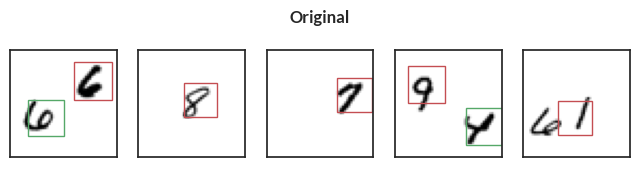

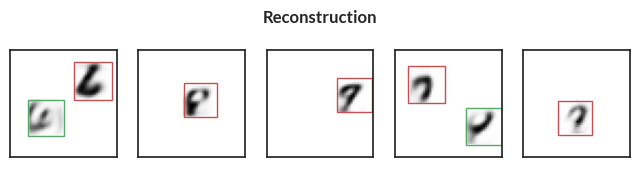

Epoch=31, total_epoch_step_time=45.64, loss=582.17
Epoch=32, total_epoch_step_time=47.05, loss=582.17
Epoch=33, total_epoch_step_time=48.50, loss=584.31
Epoch=34, total_epoch_step_time=49.95, loss=586.33
Epoch=35, total_epoch_step_time=51.37, loss=587.32
Epoch=36, total_epoch_step_time=52.80, loss=588.35
Epoch=37, total_epoch_step_time=54.24, loss=590.09
Epoch=38, total_epoch_step_time=55.66, loss=590.85
Epoch=39, total_epoch_step_time=57.10, loss=593.41
Epoch=40, total_epoch_step_time=58.53, loss=591.67
accuracy=0.6764500141143799, counts=[[17282  2666     0     0]
 [  106  9197 10197   520]
 [    2   185 14108  5737]]


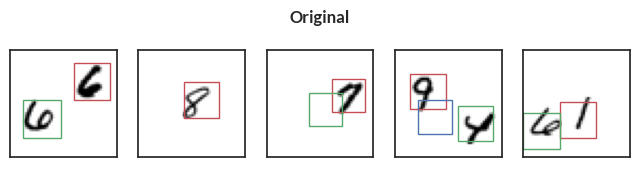

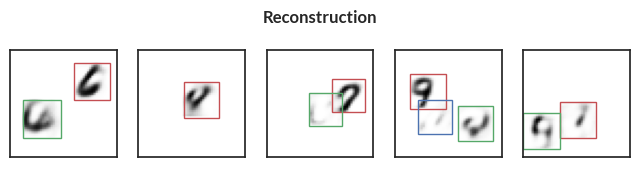

Epoch=41, total_epoch_step_time=59.96, loss=591.27
Epoch=42, total_epoch_step_time=61.37, loss=593.70
Epoch=43, total_epoch_step_time=62.81, loss=595.16
Epoch=44, total_epoch_step_time=64.23, loss=596.24
Epoch=45, total_epoch_step_time=65.65, loss=597.13
Epoch=46, total_epoch_step_time=67.12, loss=597.73
Epoch=47, total_epoch_step_time=68.53, loss=597.66
Epoch=48, total_epoch_step_time=69.94, loss=598.03
Epoch=49, total_epoch_step_time=71.39, loss=598.56
Epoch=50, total_epoch_step_time=72.82, loss=600.89
accuracy=0.7852833271026611, counts=[[18772  1176     0     0]
 [  119 11253  8417   231]
 [    5   266 17092  2669]]


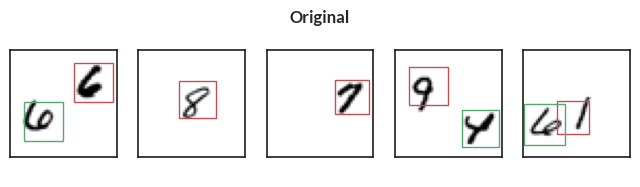

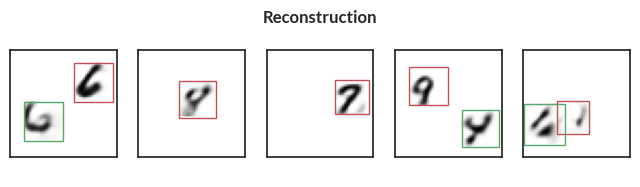

Epoch=51, total_epoch_step_time=74.26, loss=598.47
Epoch=52, total_epoch_step_time=75.69, loss=599.79
Epoch=53, total_epoch_step_time=77.12, loss=601.09
Epoch=54, total_epoch_step_time=78.56, loss=603.67
Epoch=55, total_epoch_step_time=79.99, loss=603.60
Epoch=56, total_epoch_step_time=81.45, loss=603.24
Epoch=57, total_epoch_step_time=82.87, loss=604.99
Epoch=58, total_epoch_step_time=84.27, loss=605.49
Epoch=59, total_epoch_step_time=85.72, loss=606.86
Epoch=60, total_epoch_step_time=87.15, loss=606.41
accuracy=0.8334333300590515, counts=[[19342   605     1     0]
 [  101 13778  5969   172]
 [    3   412 16886  2731]]


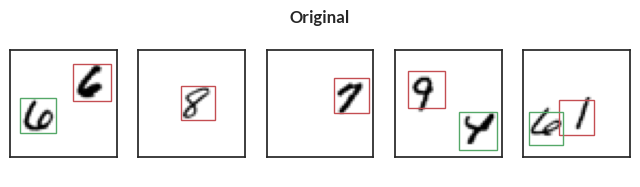

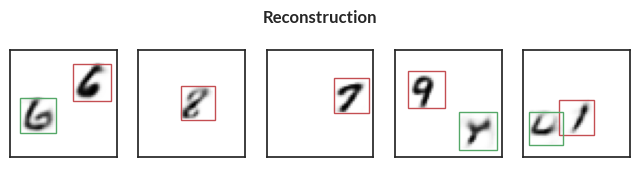

Epoch=61, total_epoch_step_time=88.61, loss=606.63
Epoch=62, total_epoch_step_time=90.04, loss=608.10
Epoch=63, total_epoch_step_time=91.47, loss=608.15
Epoch=64, total_epoch_step_time=92.91, loss=606.63
Epoch=65, total_epoch_step_time=94.35, loss=605.59
Epoch=66, total_epoch_step_time=95.80, loss=606.92
Epoch=67, total_epoch_step_time=97.23, loss=608.42
Epoch=68, total_epoch_step_time=98.71, loss=608.73
Epoch=69, total_epoch_step_time=100.16, loss=608.70
Epoch=70, total_epoch_step_time=101.61, loss=609.53
accuracy=0.8550833463668823, counts=[[19590   358     0     0]
 [  109 14483  5294   134]
 [    0   768 17232  2032]]


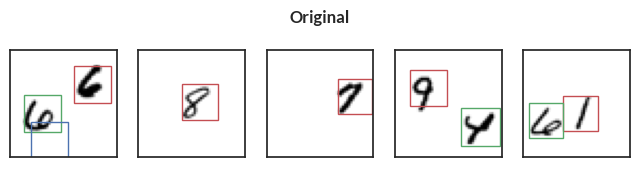

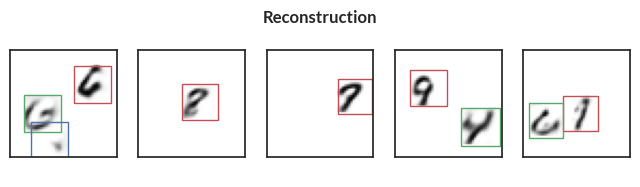

Epoch=71, total_epoch_step_time=103.06, loss=610.32
Epoch=72, total_epoch_step_time=104.47, loss=607.80
Epoch=73, total_epoch_step_time=105.91, loss=609.73
Epoch=74, total_epoch_step_time=107.35, loss=610.14
Epoch=75, total_epoch_step_time=108.81, loss=610.63
Epoch=76, total_epoch_step_time=110.24, loss=610.82
Epoch=77, total_epoch_step_time=111.68, loss=609.36
Epoch=78, total_epoch_step_time=113.12, loss=609.16
Epoch=79, total_epoch_step_time=114.56, loss=608.90
Epoch=80, total_epoch_step_time=115.99, loss=609.30
accuracy=0.8092166781425476, counts=[[19768   180     0     0]
 [   96 12329  7094   501]
 [    0   439 16456  3137]]


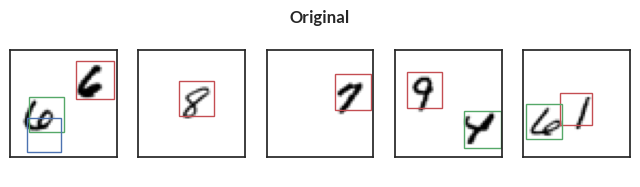

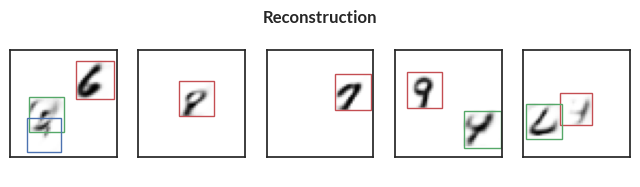

Epoch=81, total_epoch_step_time=117.44, loss=609.54
Epoch=82, total_epoch_step_time=118.86, loss=609.21
Epoch=83, total_epoch_step_time=120.32, loss=608.76
Epoch=84, total_epoch_step_time=121.78, loss=609.71
Epoch=85, total_epoch_step_time=123.21, loss=611.40
Epoch=86, total_epoch_step_time=124.65, loss=611.08
Epoch=87, total_epoch_step_time=126.10, loss=612.67
Epoch=88, total_epoch_step_time=127.55, loss=612.81
Epoch=89, total_epoch_step_time=128.99, loss=612.05
Epoch=90, total_epoch_step_time=130.44, loss=612.04
accuracy=0.8597833514213562, counts=[[19864    84     0     0]
 [   88 13942  5877   113]
 [    3   761 17781  1487]]


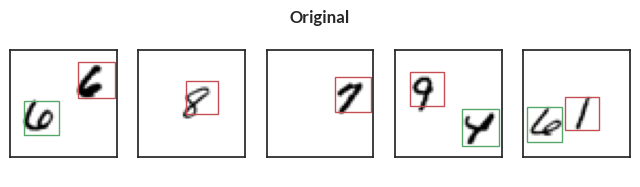

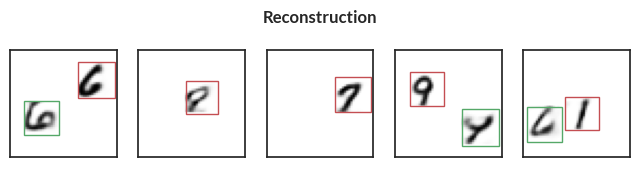

Epoch=91, total_epoch_step_time=131.90, loss=612.57
Epoch=92, total_epoch_step_time=133.32, loss=612.43
Epoch=93, total_epoch_step_time=134.72, loss=613.80
Epoch=94, total_epoch_step_time=136.10, loss=614.96
Epoch=95, total_epoch_step_time=137.48, loss=613.50
Epoch=96, total_epoch_step_time=138.85, loss=614.37
Epoch=97, total_epoch_step_time=140.23, loss=615.43
Epoch=98, total_epoch_step_time=141.61, loss=614.33
Epoch=99, total_epoch_step_time=143.00, loss=614.36
Epoch=100, total_epoch_step_time=144.37, loss=613.59
accuracy=0.7983500361442566, counts=[[19882    66     0     0]
 [   61 11128  8498   333]
 [    0   227 16891  2914]]


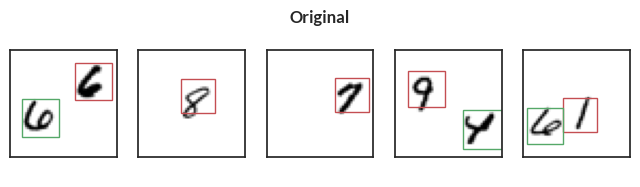

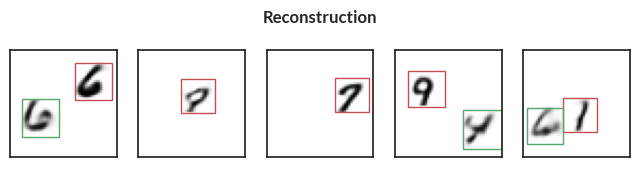

Epoch=101, total_epoch_step_time=145.75, loss=612.90
Epoch=102, total_epoch_step_time=147.13, loss=614.33
Epoch=103, total_epoch_step_time=148.51, loss=613.75
Epoch=104, total_epoch_step_time=149.90, loss=613.10
Epoch=105, total_epoch_step_time=151.30, loss=615.04
Epoch=106, total_epoch_step_time=152.70, loss=616.07
Epoch=107, total_epoch_step_time=154.09, loss=616.13
Epoch=108, total_epoch_step_time=155.46, loss=615.56
Epoch=109, total_epoch_step_time=156.84, loss=616.12
Epoch=110, total_epoch_step_time=158.22, loss=617.28
accuracy=0.9092666506767273, counts=[[19891    57     0     0]
 [   71 16642  3300     7]
 [    3  1297 18023   709]]


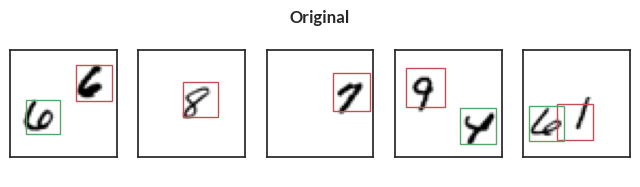

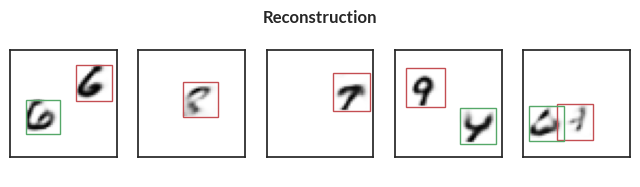

Epoch=111, total_epoch_step_time=159.59, loss=616.81
Epoch=112, total_epoch_step_time=160.97, loss=617.45
Epoch=113, total_epoch_step_time=162.34, loss=617.07
Epoch=114, total_epoch_step_time=163.71, loss=618.34
Epoch=115, total_epoch_step_time=165.11, loss=617.81
Epoch=116, total_epoch_step_time=166.48, loss=617.10
Epoch=117, total_epoch_step_time=167.86, loss=618.31
Epoch=118, total_epoch_step_time=169.24, loss=617.14
Epoch=119, total_epoch_step_time=170.61, loss=618.92
Epoch=120, total_epoch_step_time=171.99, loss=617.94
accuracy=0.8458499908447266, counts=[[19891    57     0     0]
 [   39 13094  6787   100]
 [    2   342 17766  1922]]


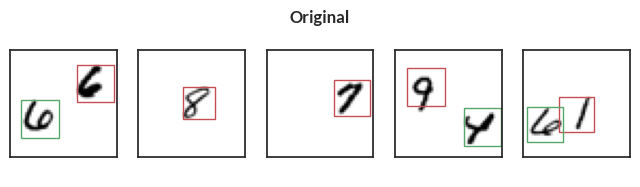

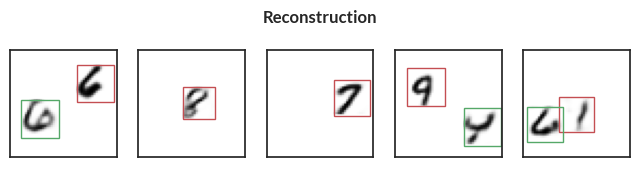

Epoch=121, total_epoch_step_time=173.37, loss=615.77
Epoch=122, total_epoch_step_time=174.76, loss=618.10
Epoch=123, total_epoch_step_time=176.14, loss=617.89
Epoch=124, total_epoch_step_time=177.51, loss=618.72
Epoch=125, total_epoch_step_time=178.89, loss=618.96
Epoch=126, total_epoch_step_time=180.27, loss=618.81
Epoch=127, total_epoch_step_time=181.65, loss=620.01
Epoch=128, total_epoch_step_time=183.01, loss=618.81
Epoch=129, total_epoch_step_time=184.38, loss=617.72
Epoch=130, total_epoch_step_time=185.76, loss=618.34
accuracy=0.8925166726112366, counts=[[19908    40     0     0]
 [   40 15407  4561    12]
 [    1   659 18236  1136]]


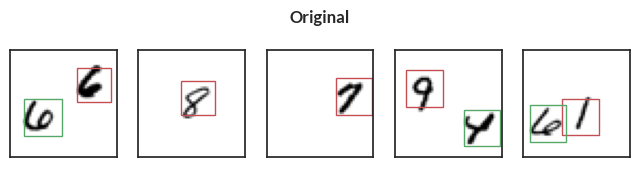

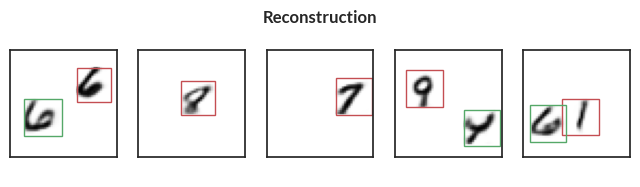

Epoch=131, total_epoch_step_time=187.12, loss=618.07
Epoch=132, total_epoch_step_time=188.50, loss=619.84
Epoch=133, total_epoch_step_time=189.88, loss=620.11
Epoch=134, total_epoch_step_time=191.26, loss=619.64
Epoch=135, total_epoch_step_time=192.63, loss=619.03
Epoch=136, total_epoch_step_time=194.02, loss=619.90
Epoch=137, total_epoch_step_time=195.38, loss=619.41
Epoch=138, total_epoch_step_time=196.75, loss=618.62
Epoch=139, total_epoch_step_time=198.13, loss=617.02
Epoch=140, total_epoch_step_time=199.49, loss=618.98
accuracy=0.9002833366394043, counts=[[19912    36     0     0]
 [   52 16713  3211    44]
 [    0  1174 17392  1466]]


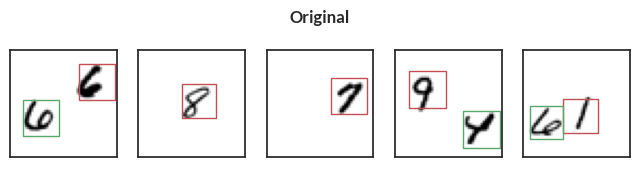

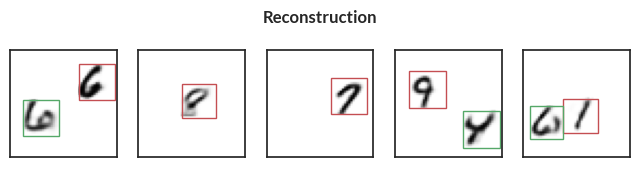

Epoch=141, total_epoch_step_time=200.85, loss=620.53
Epoch=142, total_epoch_step_time=202.23, loss=620.51
Epoch=143, total_epoch_step_time=203.60, loss=620.12
Epoch=144, total_epoch_step_time=204.96, loss=619.91
Epoch=145, total_epoch_step_time=206.34, loss=620.00
Epoch=146, total_epoch_step_time=207.71, loss=619.17
Epoch=147, total_epoch_step_time=209.07, loss=620.27
Epoch=148, total_epoch_step_time=210.44, loss=621.74
Epoch=149, total_epoch_step_time=211.80, loss=622.23
Epoch=150, total_epoch_step_time=213.17, loss=621.77
accuracy=0.9215333461761475, counts=[[19927    21     0     0]
 [   63 17641  2316     0]
 [    4  1560 17724   744]]


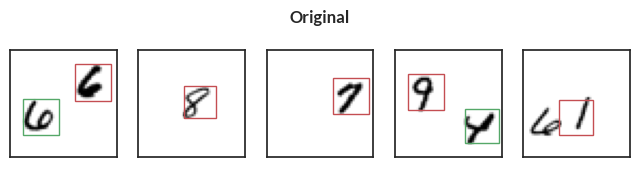

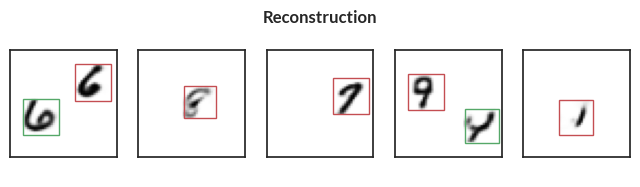

Epoch=151, total_epoch_step_time=214.54, loss=621.23
Epoch=152, total_epoch_step_time=215.93, loss=621.07
Epoch=153, total_epoch_step_time=217.33, loss=620.49
Epoch=154, total_epoch_step_time=218.72, loss=622.04
Epoch=155, total_epoch_step_time=220.11, loss=621.82
Epoch=156, total_epoch_step_time=221.52, loss=621.39
Epoch=157, total_epoch_step_time=222.91, loss=621.91
Epoch=158, total_epoch_step_time=224.31, loss=622.19
Epoch=159, total_epoch_step_time=225.71, loss=621.33
Epoch=160, total_epoch_step_time=227.11, loss=620.71
accuracy=0.8765333294868469, counts=[[19906    42     0     0]
 [   35 13616  6368     1]
 [    2   339 19070   621]]


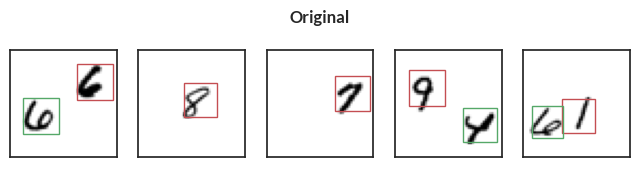

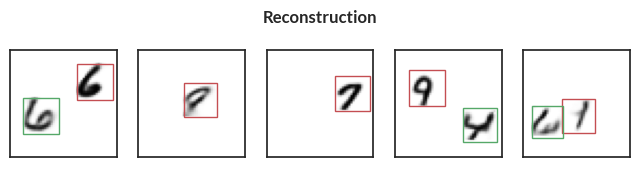

Epoch=161, total_epoch_step_time=228.47, loss=620.72
Epoch=162, total_epoch_step_time=229.85, loss=620.81
Epoch=163, total_epoch_step_time=231.22, loss=619.76
Epoch=164, total_epoch_step_time=232.59, loss=620.80
Epoch=165, total_epoch_step_time=233.97, loss=621.35
Epoch=166, total_epoch_step_time=235.34, loss=621.47
Epoch=167, total_epoch_step_time=236.72, loss=621.24
Epoch=168, total_epoch_step_time=238.10, loss=619.21
Epoch=169, total_epoch_step_time=239.49, loss=620.76
Epoch=170, total_epoch_step_time=240.87, loss=622.28
accuracy=0.9092167019844055, counts=[[19929    19     0     0]
 [   38 16016  3964     2]
 [    4   736 18608   684]]


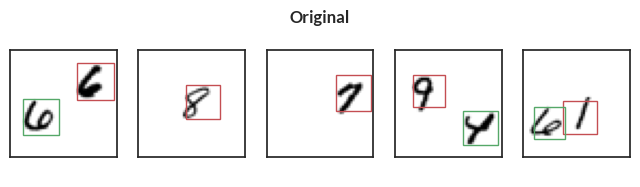

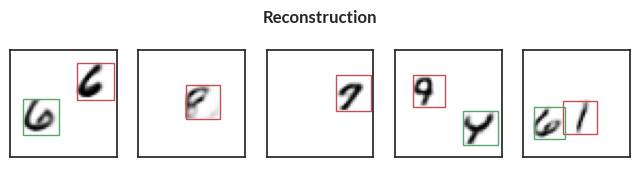

Epoch=171, total_epoch_step_time=242.23, loss=622.56
Epoch=172, total_epoch_step_time=243.62, loss=622.71
Epoch=173, total_epoch_step_time=244.99, loss=621.31
Epoch=174, total_epoch_step_time=246.35, loss=624.00
Epoch=175, total_epoch_step_time=247.72, loss=622.38
Epoch=176, total_epoch_step_time=249.09, loss=622.64
Epoch=177, total_epoch_step_time=250.45, loss=621.67
Epoch=178, total_epoch_step_time=251.82, loss=622.72
Epoch=179, total_epoch_step_time=253.19, loss=622.94
Epoch=180, total_epoch_step_time=254.56, loss=622.40
accuracy=0.9192667007446289, counts=[[19933    15     0     0]
 [   35 16565  3417     3]
 [    1   850 18658   523]]


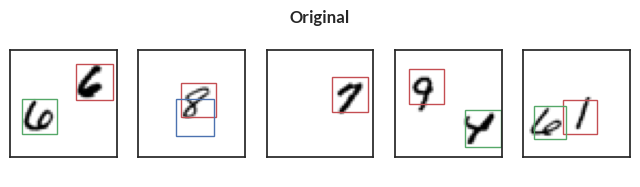

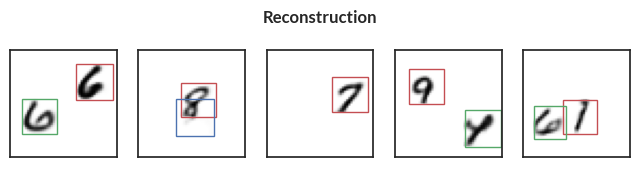

Epoch=181, total_epoch_step_time=255.93, loss=622.30
Epoch=182, total_epoch_step_time=257.31, loss=622.78
Epoch=183, total_epoch_step_time=258.69, loss=622.58
Epoch=184, total_epoch_step_time=260.05, loss=622.31
Epoch=185, total_epoch_step_time=261.42, loss=624.45
Epoch=186, total_epoch_step_time=262.80, loss=623.73
Epoch=187, total_epoch_step_time=264.18, loss=622.51
Epoch=188, total_epoch_step_time=265.56, loss=621.23
Epoch=189, total_epoch_step_time=266.94, loss=623.17
Epoch=190, total_epoch_step_time=268.32, loss=622.55
accuracy=0.923133373260498, counts=[[19930    18     0     0]
 [   25 17193  2800     2]
 [    1   878 18265   888]]


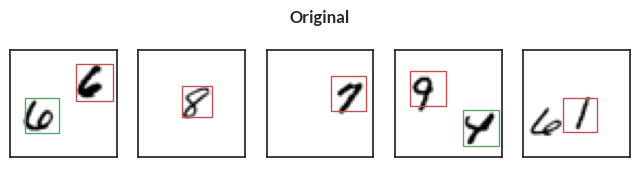

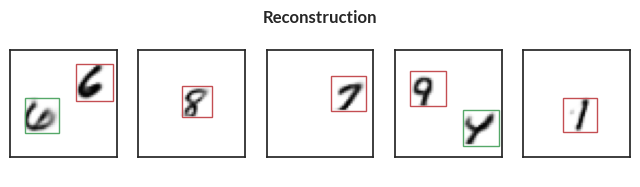

Epoch=191, total_epoch_step_time=269.69, loss=623.58
Epoch=192, total_epoch_step_time=271.07, loss=624.01
Epoch=193, total_epoch_step_time=272.46, loss=623.85
Epoch=194, total_epoch_step_time=273.83, loss=623.68
Epoch=195, total_epoch_step_time=275.22, loss=622.78
Epoch=196, total_epoch_step_time=276.60, loss=623.38
Epoch=197, total_epoch_step_time=277.99, loss=621.61
Epoch=198, total_epoch_step_time=279.36, loss=623.73
Epoch=199, total_epoch_step_time=280.75, loss=622.70
Epoch=200, total_epoch_step_time=282.13, loss=624.83
accuracy=0.8862833380699158, counts=[[19935    13     0     0]
 [   19 14916  5041    44]
 [    4   411 18326  1291]]


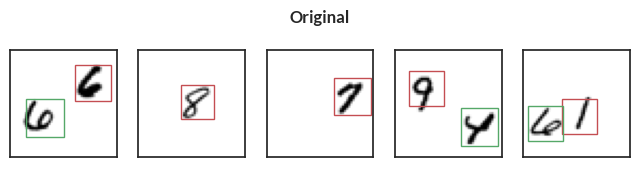

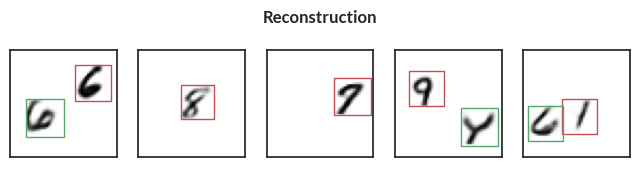

In [17]:
key, sub_key = jax.random.split(key)
losses, accuracy, wall_clock_times, params = train(
    sub_key, n=1, learning_rate=1.0e-4, num_epochs=200
)

In [18]:
arr = np.array([losses, accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["ELBO Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv("./training_runs/grasp_air_reinforce_epochs_201_mccoy_prior.csv", index=False)

Epoch=0, total_epoch_step_time=2.11, loss=249.03
accuracy=0.2521333396434784, counts=[[11191  6772  1761   224]
 [15813  3818   360    29]
 [17837  2067   119     9]]


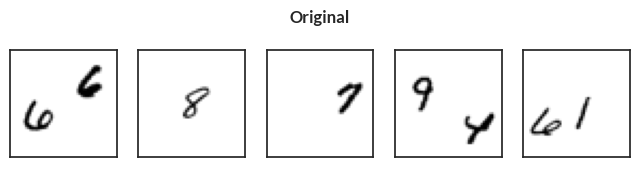

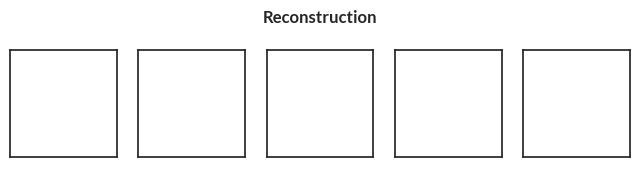

Epoch=1, total_epoch_step_time=4.28, loss=427.25
Epoch=2, total_epoch_step_time=6.45, loss=447.39
Epoch=3, total_epoch_step_time=8.61, loss=461.93
Epoch=4, total_epoch_step_time=10.78, loss=477.33
Epoch=5, total_epoch_step_time=12.94, loss=499.08
Epoch=6, total_epoch_step_time=15.11, loss=517.09
Epoch=7, total_epoch_step_time=17.28, loss=532.05
Epoch=8, total_epoch_step_time=19.45, loss=543.58
Epoch=9, total_epoch_step_time=21.62, loss=553.92
Epoch=10, total_epoch_step_time=23.79, loss=562.16
accuracy=0.6840833425521851, counts=[[12186  7247   511     4]
 [ 1676 14336  3962    46]
 [  293  4442 14523   774]]


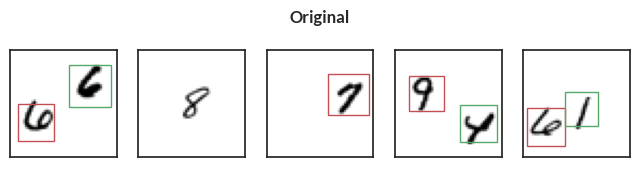

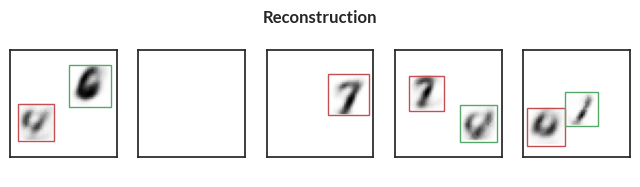

Epoch=11, total_epoch_step_time=25.96, loss=567.30
Epoch=12, total_epoch_step_time=28.15, loss=571.89
Epoch=13, total_epoch_step_time=30.33, loss=576.75
Epoch=14, total_epoch_step_time=32.50, loss=580.39
Epoch=15, total_epoch_step_time=34.67, loss=583.47
Epoch=16, total_epoch_step_time=36.85, loss=586.31
Epoch=17, total_epoch_step_time=39.02, loss=588.63
Epoch=18, total_epoch_step_time=41.21, loss=590.76
Epoch=19, total_epoch_step_time=43.38, loss=592.72
Epoch=20, total_epoch_step_time=45.56, loss=594.13
accuracy=0.7353333234786987, counts=[[14459  5391    98     0]
 [  792 11804  7406    18]
 [   60  1735 17857   380]]


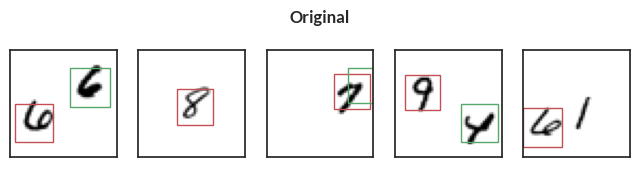

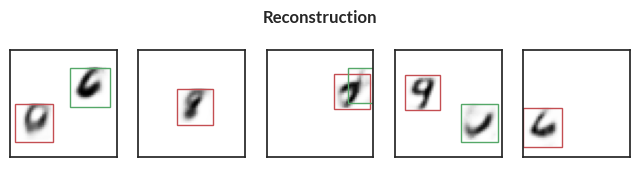

Epoch=21, total_epoch_step_time=47.72, loss=596.26
Epoch=22, total_epoch_step_time=49.91, loss=596.78
Epoch=23, total_epoch_step_time=52.09, loss=598.30
Epoch=24, total_epoch_step_time=54.27, loss=599.76
Epoch=25, total_epoch_step_time=56.46, loss=601.66
Epoch=26, total_epoch_step_time=58.64, loss=602.15
Epoch=27, total_epoch_step_time=60.82, loss=603.91
Epoch=28, total_epoch_step_time=63.00, loss=604.39
Epoch=29, total_epoch_step_time=65.18, loss=606.25
Epoch=30, total_epoch_step_time=67.37, loss=606.71
accuracy=0.8464666604995728, counts=[[16171  3753    24     0]
 [  527 17433  2059     1]
 [   22  2791 17184    35]]


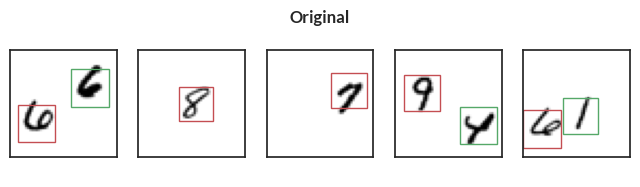

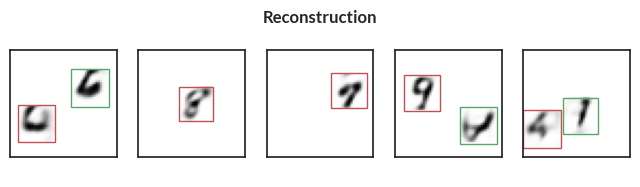

Epoch=31, total_epoch_step_time=69.55, loss=607.61
Epoch=32, total_epoch_step_time=71.73, loss=606.67
Epoch=33, total_epoch_step_time=73.90, loss=606.76
Epoch=34, total_epoch_step_time=76.10, loss=609.14
Epoch=35, total_epoch_step_time=78.27, loss=610.40
Epoch=36, total_epoch_step_time=80.46, loss=611.10
Epoch=37, total_epoch_step_time=82.63, loss=612.57
Epoch=38, total_epoch_step_time=84.82, loss=612.18
Epoch=39, total_epoch_step_time=87.00, loss=612.97
Epoch=40, total_epoch_step_time=89.18, loss=613.88
accuracy=0.8633000254631042, counts=[[17694  2247     7     0]
 [  431 15539  4048     2]
 [   16  1320 18565   131]]


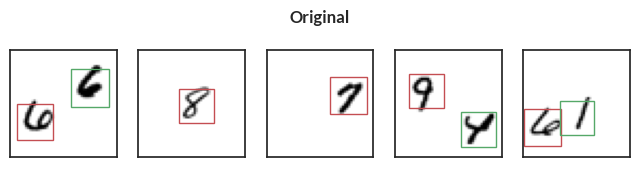

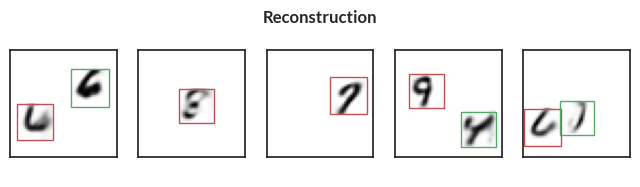

Epoch=41, total_epoch_step_time=91.36, loss=614.09
Epoch=42, total_epoch_step_time=93.54, loss=613.98
Epoch=43, total_epoch_step_time=95.72, loss=614.89
Epoch=44, total_epoch_step_time=97.91, loss=615.68
Epoch=45, total_epoch_step_time=100.08, loss=616.22
Epoch=46, total_epoch_step_time=102.25, loss=616.22
Epoch=47, total_epoch_step_time=104.41, loss=617.03
Epoch=48, total_epoch_step_time=106.61, loss=617.11
Epoch=49, total_epoch_step_time=108.79, loss=617.93
Epoch=50, total_epoch_step_time=110.97, loss=617.95
accuracy=0.8794833421707153, counts=[[17889  2052     7     0]
 [  419 17138  2462     1]
 [   12  2237 17742    41]]


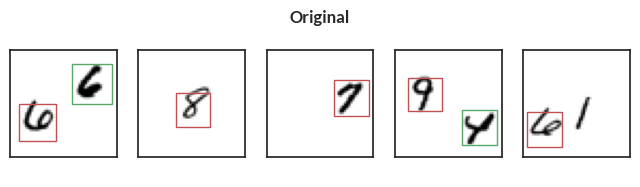

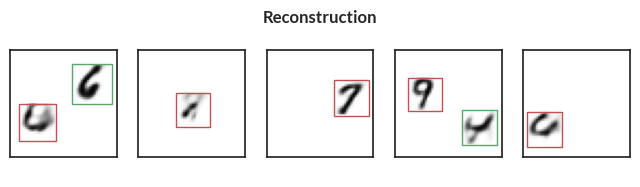

Epoch=51, total_epoch_step_time=113.14, loss=618.50
Epoch=52, total_epoch_step_time=115.32, loss=618.89
Epoch=53, total_epoch_step_time=117.50, loss=618.16
Epoch=54, total_epoch_step_time=119.67, loss=618.58
Epoch=55, total_epoch_step_time=121.84, loss=617.94
Epoch=56, total_epoch_step_time=124.03, loss=619.47
Epoch=57, total_epoch_step_time=126.21, loss=619.53
Epoch=58, total_epoch_step_time=128.39, loss=620.14
Epoch=59, total_epoch_step_time=130.58, loss=620.63
Epoch=60, total_epoch_step_time=132.76, loss=621.74
accuracy=0.8901333212852478, counts=[[18579  1369     0     0]
 [  384 15752  3884     0]
 [   14   871 19077    70]]


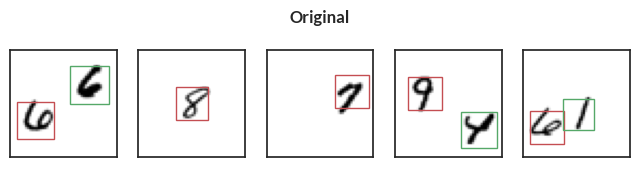

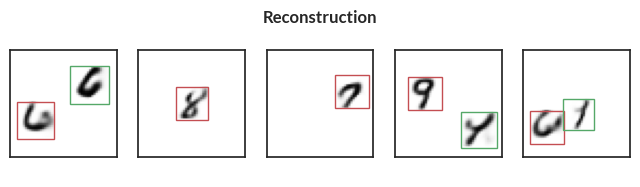

Epoch=61, total_epoch_step_time=134.92, loss=621.16
Epoch=62, total_epoch_step_time=137.10, loss=621.51
Epoch=63, total_epoch_step_time=139.27, loss=621.45
Epoch=64, total_epoch_step_time=141.44, loss=620.99
Epoch=65, total_epoch_step_time=143.61, loss=620.38
Epoch=66, total_epoch_step_time=145.78, loss=621.22
Epoch=67, total_epoch_step_time=147.97, loss=621.62
Epoch=68, total_epoch_step_time=150.14, loss=622.10
Epoch=69, total_epoch_step_time=152.34, loss=621.17
Epoch=70, total_epoch_step_time=154.68, loss=622.07
accuracy=0.8869500160217285, counts=[[18661  1287     0     0]
 [  286 15898  3833     3]
 [    8  1320 18658    46]]


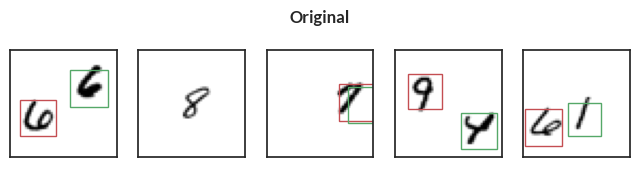

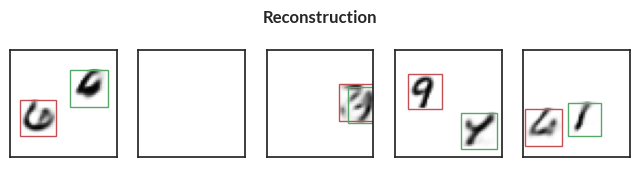

Epoch=71, total_epoch_step_time=156.88, loss=620.66
Epoch=72, total_epoch_step_time=159.08, loss=621.16
Epoch=73, total_epoch_step_time=161.37, loss=621.70
Epoch=74, total_epoch_step_time=163.60, loss=621.73
Epoch=75, total_epoch_step_time=165.79, loss=621.98
Epoch=76, total_epoch_step_time=167.97, loss=623.07
Epoch=77, total_epoch_step_time=170.14, loss=623.49
Epoch=78, total_epoch_step_time=172.32, loss=624.25
Epoch=79, total_epoch_step_time=174.49, loss=622.24
Epoch=80, total_epoch_step_time=176.67, loss=623.82
accuracy=0.8986166715621948, counts=[[19111   837     0     0]
 [  257 15798  3962     3]
 [    9   968 19008    47]]


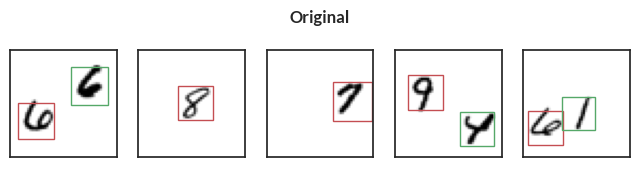

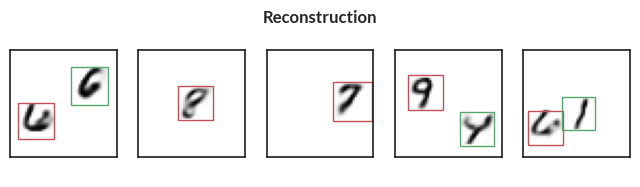

Epoch=81, total_epoch_step_time=178.83, loss=624.60
Epoch=82, total_epoch_step_time=181.01, loss=625.42
Epoch=83, total_epoch_step_time=183.18, loss=624.42
Epoch=84, total_epoch_step_time=185.37, loss=624.16
Epoch=85, total_epoch_step_time=187.55, loss=624.95
Epoch=86, total_epoch_step_time=189.74, loss=625.36
Epoch=87, total_epoch_step_time=191.91, loss=624.97
Epoch=88, total_epoch_step_time=194.08, loss=624.55
Epoch=89, total_epoch_step_time=196.25, loss=625.03
Epoch=90, total_epoch_step_time=198.44, loss=625.68
accuracy=0.9169000387191772, counts=[[19103   844     1     0]
 [  201 17091  2727     1]
 [    4  1185 18820    23]]


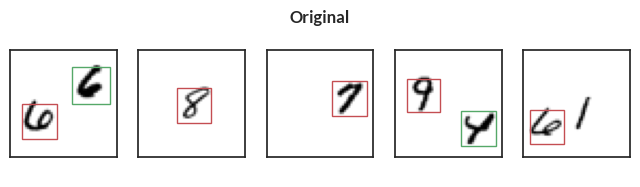

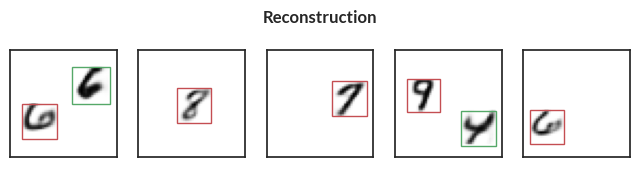

Epoch=91, total_epoch_step_time=200.60, loss=625.62
Epoch=92, total_epoch_step_time=202.79, loss=624.47
Epoch=93, total_epoch_step_time=205.05, loss=624.13
Epoch=94, total_epoch_step_time=207.25, loss=625.38
Epoch=95, total_epoch_step_time=209.44, loss=627.07
Epoch=96, total_epoch_step_time=211.63, loss=626.34
Epoch=97, total_epoch_step_time=213.82, loss=625.84
Epoch=98, total_epoch_step_time=216.00, loss=626.60
Epoch=99, total_epoch_step_time=218.19, loss=625.75
Epoch=100, total_epoch_step_time=220.38, loss=625.90
accuracy=0.9208999872207642, counts=[[19187   761     0     0]
 [  172 17324  2524     0]
 [    3  1272 18743    14]]


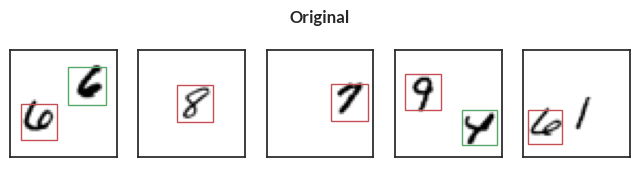

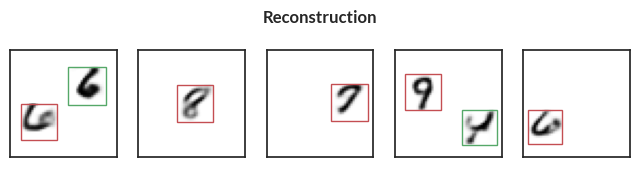

Epoch=101, total_epoch_step_time=222.58, loss=626.63
Epoch=102, total_epoch_step_time=224.82, loss=627.18
Epoch=103, total_epoch_step_time=227.05, loss=625.91
Epoch=104, total_epoch_step_time=229.22, loss=627.31
Epoch=105, total_epoch_step_time=231.40, loss=627.98
Epoch=106, total_epoch_step_time=233.57, loss=625.76
Epoch=107, total_epoch_step_time=235.75, loss=625.91
Epoch=108, total_epoch_step_time=237.93, loss=626.11
Epoch=109, total_epoch_step_time=240.11, loss=626.63
Epoch=110, total_epoch_step_time=242.29, loss=625.19
accuracy=0.8931500315666199, counts=[[19218   730     0     0]
 [  155 14984  4878     3]
 [    5   576 19387    64]]


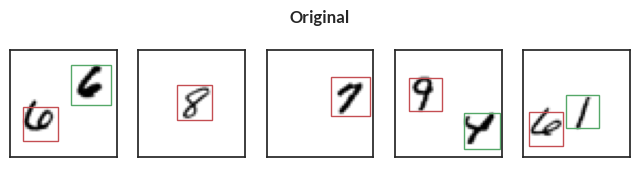

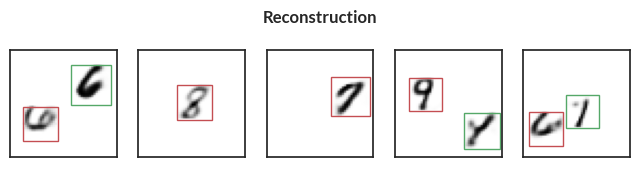

Epoch=111, total_epoch_step_time=244.53, loss=626.27
Epoch=112, total_epoch_step_time=246.71, loss=626.73
Epoch=113, total_epoch_step_time=248.98, loss=626.88
Epoch=114, total_epoch_step_time=251.28, loss=626.74
Epoch=115, total_epoch_step_time=253.46, loss=627.08
Epoch=116, total_epoch_step_time=255.57, loss=627.32
Epoch=117, total_epoch_step_time=257.67, loss=627.88
Epoch=118, total_epoch_step_time=259.78, loss=627.89
Epoch=119, total_epoch_step_time=261.89, loss=627.47
Epoch=120, total_epoch_step_time=263.99, loss=626.08
accuracy=0.8853333592414856, counts=[[19226   722     0     0]
 [  121 14593  5303     3]
 [    4   690 19301    37]]


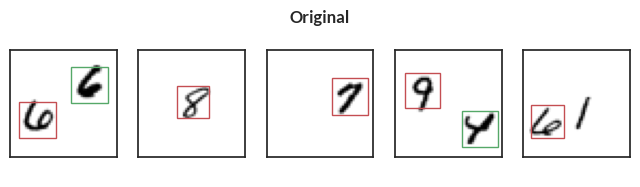

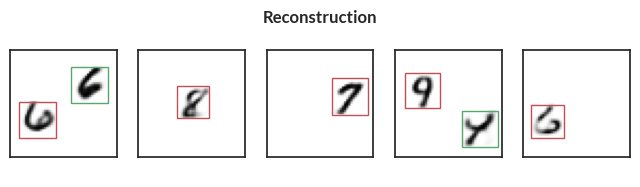

Epoch=121, total_epoch_step_time=266.18, loss=626.08
Epoch=122, total_epoch_step_time=268.37, loss=627.18
Epoch=123, total_epoch_step_time=270.55, loss=625.99
Epoch=124, total_epoch_step_time=272.72, loss=626.61
Epoch=125, total_epoch_step_time=274.89, loss=626.57
Epoch=126, total_epoch_step_time=277.06, loss=627.42
Epoch=127, total_epoch_step_time=279.30, loss=628.34
Epoch=128, total_epoch_step_time=281.53, loss=628.86
Epoch=129, total_epoch_step_time=283.70, loss=626.62
Epoch=130, total_epoch_step_time=285.90, loss=627.08
accuracy=0.8990166783332825, counts=[[19327   621     0     0]
 [  198 15465  4355     2]
 [    3   859 19149    21]]


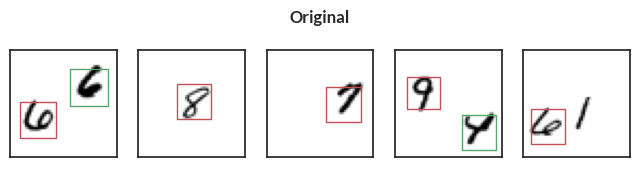

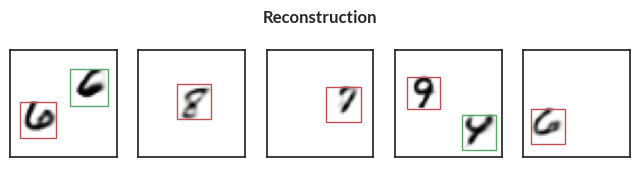

Epoch=131, total_epoch_step_time=288.06, loss=627.19
Epoch=132, total_epoch_step_time=290.24, loss=628.73
Epoch=133, total_epoch_step_time=292.42, loss=629.01
Epoch=134, total_epoch_step_time=294.59, loss=628.38
Epoch=135, total_epoch_step_time=296.77, loss=629.13
Epoch=136, total_epoch_step_time=298.95, loss=628.88
Epoch=137, total_epoch_step_time=301.13, loss=628.02
Epoch=138, total_epoch_step_time=303.30, loss=628.65
Epoch=139, total_epoch_step_time=305.48, loss=629.24
Epoch=140, total_epoch_step_time=307.66, loss=629.37
accuracy=0.939383327960968, counts=[[19470   478     0     0]
 [  161 18513  1344     2]
 [    5  1641 18380     6]]


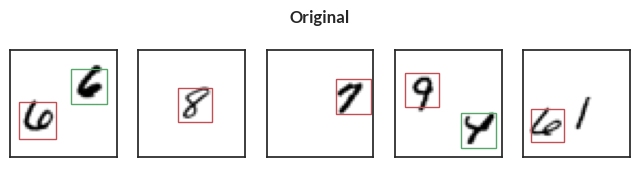

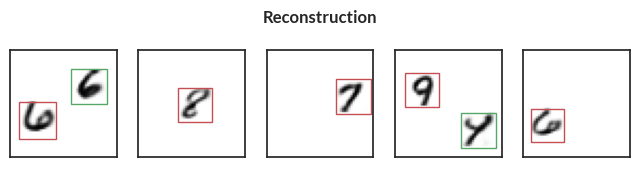

Epoch=141, total_epoch_step_time=309.84, loss=629.57
Epoch=142, total_epoch_step_time=312.02, loss=629.63
Epoch=143, total_epoch_step_time=314.19, loss=628.41
Epoch=144, total_epoch_step_time=316.36, loss=627.50
Epoch=145, total_epoch_step_time=318.53, loss=628.75
Epoch=146, total_epoch_step_time=320.71, loss=628.72
Epoch=147, total_epoch_step_time=322.88, loss=628.81
Epoch=148, total_epoch_step_time=325.06, loss=628.67
Epoch=149, total_epoch_step_time=327.25, loss=629.87
Epoch=150, total_epoch_step_time=329.43, loss=630.09
accuracy=0.9264000058174133, counts=[[19390   558     0     0]
 [  145 17030  2844     1]
 [    2   856 19164    10]]


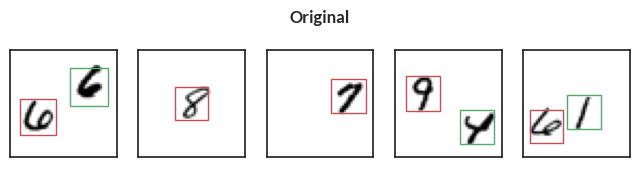

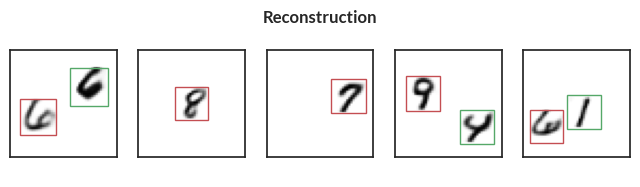

Epoch=151, total_epoch_step_time=331.59, loss=629.86
Epoch=152, total_epoch_step_time=333.80, loss=630.27
Epoch=153, total_epoch_step_time=335.98, loss=629.54
Epoch=154, total_epoch_step_time=338.15, loss=629.31
Epoch=155, total_epoch_step_time=340.33, loss=629.91
Epoch=156, total_epoch_step_time=342.51, loss=630.57
Epoch=157, total_epoch_step_time=344.69, loss=631.16
Epoch=158, total_epoch_step_time=346.87, loss=630.59
Epoch=159, total_epoch_step_time=349.04, loss=629.52
Epoch=160, total_epoch_step_time=351.21, loss=629.25
accuracy=0.8948166966438293, counts=[[19603   345     0     0]
 [   77 14361  5580     2]
 [    6   259 19725    42]]


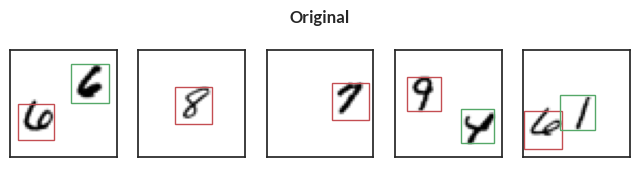

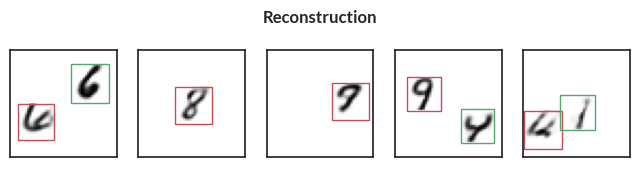

Epoch=161, total_epoch_step_time=353.38, loss=628.79
Epoch=162, total_epoch_step_time=355.54, loss=629.19
Epoch=163, total_epoch_step_time=357.73, loss=628.54
Epoch=164, total_epoch_step_time=359.91, loss=628.93
Epoch=165, total_epoch_step_time=362.10, loss=630.56
Epoch=166, total_epoch_step_time=364.27, loss=630.27
Epoch=167, total_epoch_step_time=366.45, loss=630.25
Epoch=168, total_epoch_step_time=368.62, loss=630.03
Epoch=169, total_epoch_step_time=370.79, loss=630.98
Epoch=170, total_epoch_step_time=372.96, loss=631.48
accuracy=0.9453499913215637, counts=[[19653   295     0     0]
 [  122 18399  1498     1]
 [    3  1350 18669    10]]


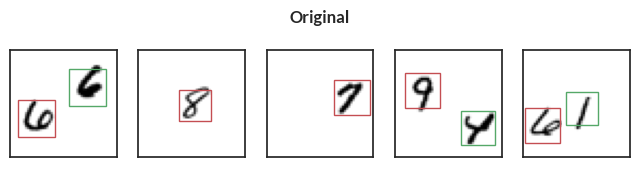

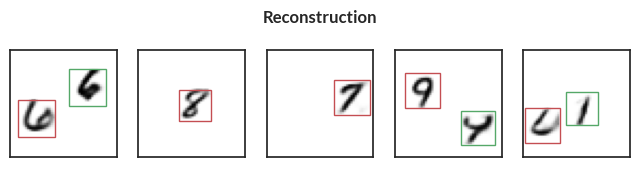

Epoch=171, total_epoch_step_time=375.14, loss=631.69
Epoch=172, total_epoch_step_time=377.31, loss=631.25
Epoch=173, total_epoch_step_time=379.48, loss=631.65
Epoch=174, total_epoch_step_time=381.65, loss=630.81
Epoch=175, total_epoch_step_time=383.83, loss=631.15
Epoch=176, total_epoch_step_time=386.01, loss=630.55
Epoch=177, total_epoch_step_time=388.19, loss=630.54
Epoch=178, total_epoch_step_time=390.36, loss=631.31
Epoch=179, total_epoch_step_time=392.54, loss=631.48
Epoch=180, total_epoch_step_time=394.71, loss=630.10
accuracy=0.8946666717529297, counts=[[19642   306     0     0]
 [   96 14365  5556     3]
 [    2   306 19673    51]]


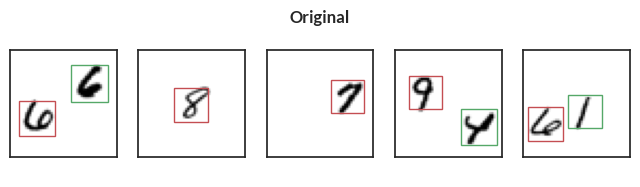

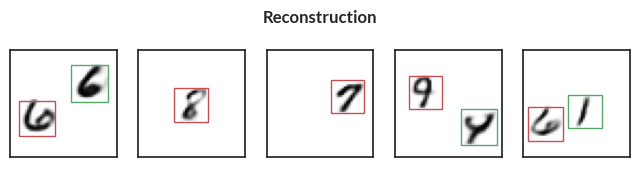

Epoch=181, total_epoch_step_time=396.88, loss=630.77
Epoch=182, total_epoch_step_time=399.05, loss=631.08
Epoch=183, total_epoch_step_time=401.23, loss=630.93
Epoch=184, total_epoch_step_time=403.41, loss=631.54
Epoch=185, total_epoch_step_time=405.59, loss=630.21
Epoch=186, total_epoch_step_time=407.77, loss=629.64
Epoch=187, total_epoch_step_time=409.96, loss=631.65
Epoch=188, total_epoch_step_time=412.18, loss=631.23
Epoch=189, total_epoch_step_time=414.39, loss=631.73
Epoch=190, total_epoch_step_time=416.57, loss=631.77
accuracy=0.9449000358581543, counts=[[19675   273     0     0]
 [   88 18126  1805     1]
 [    1  1124 18893    14]]


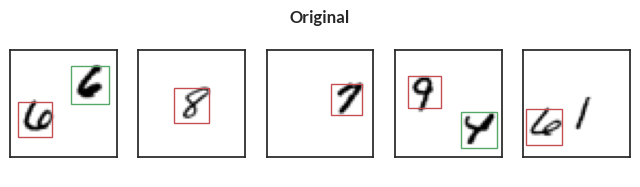

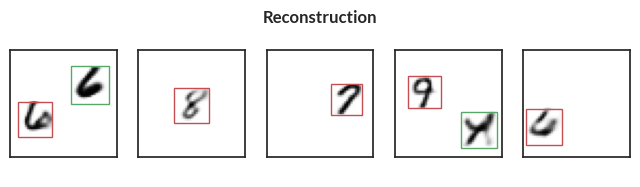

Epoch=191, total_epoch_step_time=418.74, loss=632.12
Epoch=192, total_epoch_step_time=420.92, loss=631.99
Epoch=193, total_epoch_step_time=423.09, loss=631.22
Epoch=194, total_epoch_step_time=425.26, loss=632.07
Epoch=195, total_epoch_step_time=427.45, loss=632.60
Epoch=196, total_epoch_step_time=429.63, loss=632.01
Epoch=197, total_epoch_step_time=431.80, loss=631.79
Epoch=198, total_epoch_step_time=433.98, loss=632.32
Epoch=199, total_epoch_step_time=436.15, loss=632.34
Epoch=200, total_epoch_step_time=438.32, loss=631.93
accuracy=0.9153500199317932, counts=[[19662   286     0     0]
 [  108 15993  3916     3]
 [    4   727 19266    35]]


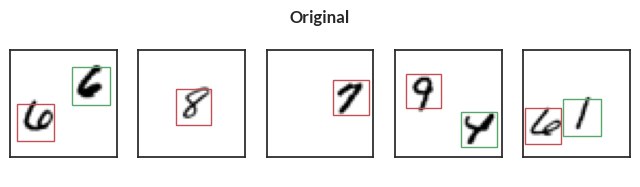

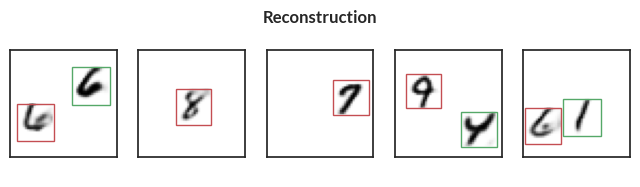

In [19]:
key, sub_key = jax.random.split(key)
losses, accuracy, wall_clock_times, params = train(
    sub_key, n=2, num_epochs=200, learning_rate=1.0e-4
)

In [20]:
arr = np.array([losses, accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["ELBO Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv(
    "./training_runs/grasp_air_iwae_2_reinforce_epochs_201_mccoy_prior.csv", index=False
)